In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#import tensorflow as tf
#print(tf.config.list_physical_devices('GPU'))

In [3]:
input_paths = [
    "results/test_video"
    #"results/diti_02_04_kocyk_bez_zabawek",
    #"results/diti_06_05_kocyk_bez_zabawek",
    #"results/diti_11_04_kocyk_bez_zabawek",
    #"results/diti_12_04_kocyk_bez_zabawek",
    #"results/diti_19_04_kocyk_bez_zabawek",
    #"results/diti_21_04_kocyk_bez_zabawek",
]

input_paths_i = [path + "/Kamera_1_infant_short.csv" for path in input_paths]
input_paths_a = [path + "/Kamera_2_adult_short.csv" for path in input_paths]

df_infant_arr = [pd.read_csv(input_path_i) for input_path_i in input_paths_i]
df_adult_arr = [pd.read_csv(input_path_a) for input_path_a in input_paths_a]

def fix_dataframe(df):
    return pd.DataFrame({"Frame": range(0, df["Frame"].max() + 1)}).merge(df, on="Frame", how="left").fillna(-1)

# Trim the longer videos
for i, (inf, adu) in enumerate(zip(df_infant_arr, df_adult_arr)):
    inf = fix_dataframe(inf)
    adu = fix_dataframe(adu)
    min_len = min(len(inf), len(adu))
    df_infant_arr[i] = inf.tail(min_len)
    df_adult_arr[i] = adu.tail(min_len)

df_infant = pd.concat(df_infant_arr, ignore_index=True)
df_adult = pd.concat(df_adult_arr, ignore_index=True)

In [4]:
# Drop unnecessary columns
df_infant_full_processed = df_infant.drop("Frame", axis=1)
df_adult_full_processed = df_adult.drop("Frame", axis=1)

# Drop rows with -1
mask = ~((df_infant_full_processed == -1) | (df_adult_full_processed == -1)).any(axis=1)
df_infant_processed = df_infant_full_processed.loc[mask]
df_adult_processed = df_adult_full_processed.loc[mask]

AUs = list(df_infant_processed.columns)
print(AUs)

['Occ_au_1', 'Occ_au_2', 'Occ_au_3', 'Occ_au_4', 'Occ_au_6', 'Occ_au_9', 'Occ_au_12', 'Occ_au_20', 'Occ_au_28']


## Self Correlation

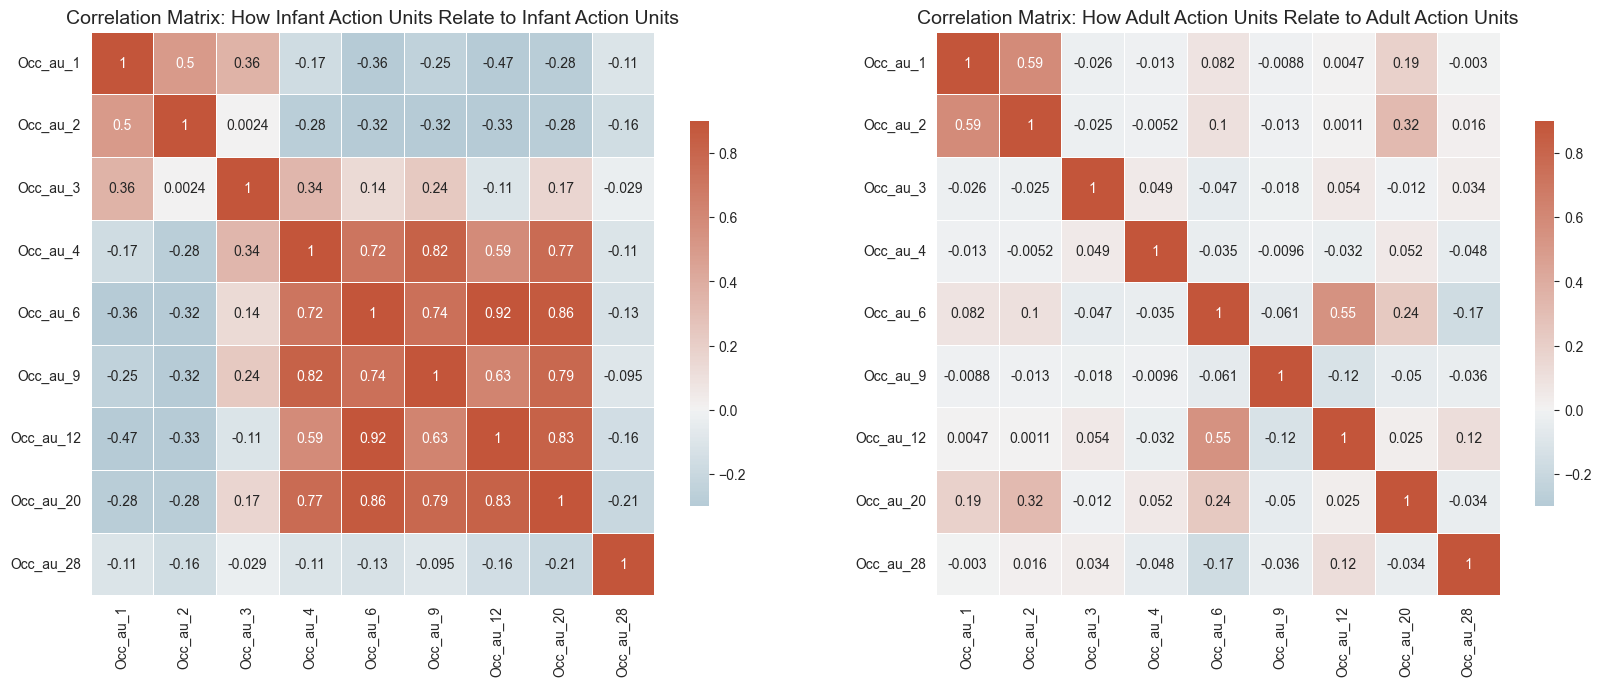

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for i, (df, name) in enumerate([(df_infant_processed, 'Infant'), (df_adult_processed, 'Adult')]):
    ax = axes[i]
    
    corr = df.corr(numeric_only=True)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=None, cmap=cmap, vmax=.9, vmin=-.3, center=0, ax=ax,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    ax.set_title(f"Correlation Matrix: How {name} Action Units Relate to {name} Action Units", fontsize=14)
plt.show()

## Adult vs Infant Correlation

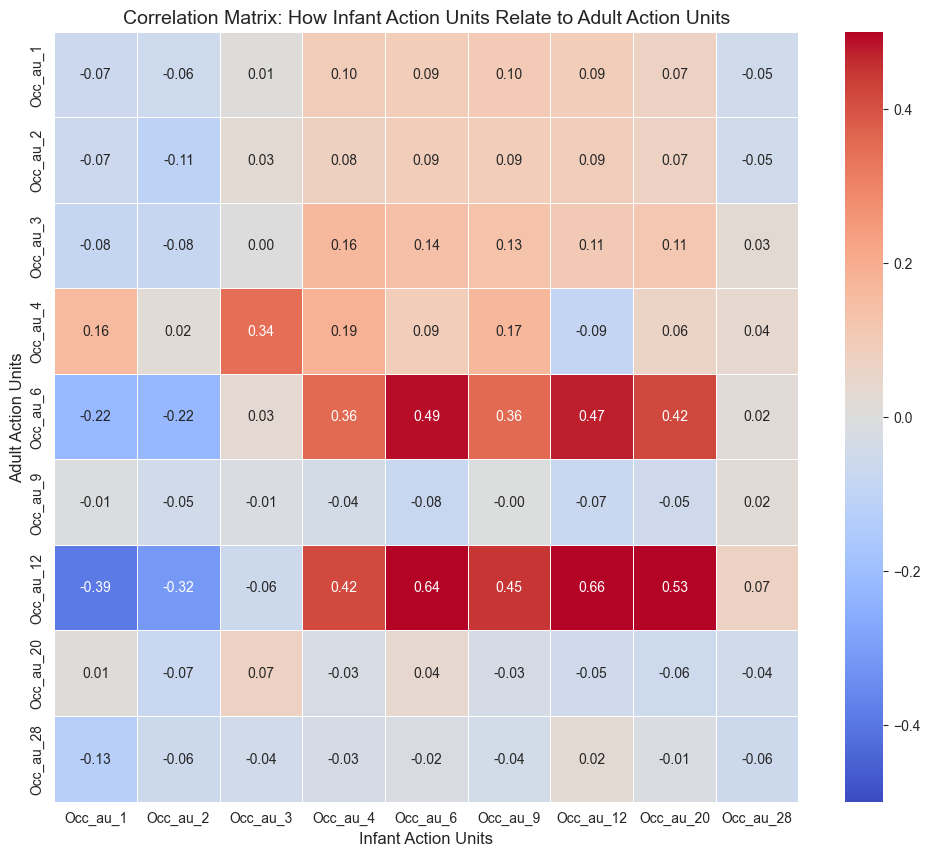

In [6]:
full_corr_matrix = pd.DataFrame(index=df_adult_processed.columns, columns=df_infant_processed.columns)

for col1 in df_adult_processed.columns:
    for col2 in df_infant_processed.columns:
        full_corr_matrix.loc[col1, col2] = df_adult_processed[col1].corr(df_infant_processed[col2])

plt.figure(figsize=(12, 10))
ax = sns.heatmap(full_corr_matrix.astype(float), annot=True, cmap='coolwarm', vmax=.5, vmin=-.5,
                 fmt='.2f', cbar=True, linewidths=0.5)
ax.set_xlabel("Infant Action Units", fontsize=12)
ax.set_ylabel("Adult Action Units", fontsize=12)
ax.set_title("Correlation Matrix: How Infant Action Units Relate to Adult Action Units", fontsize=14)
plt.show()

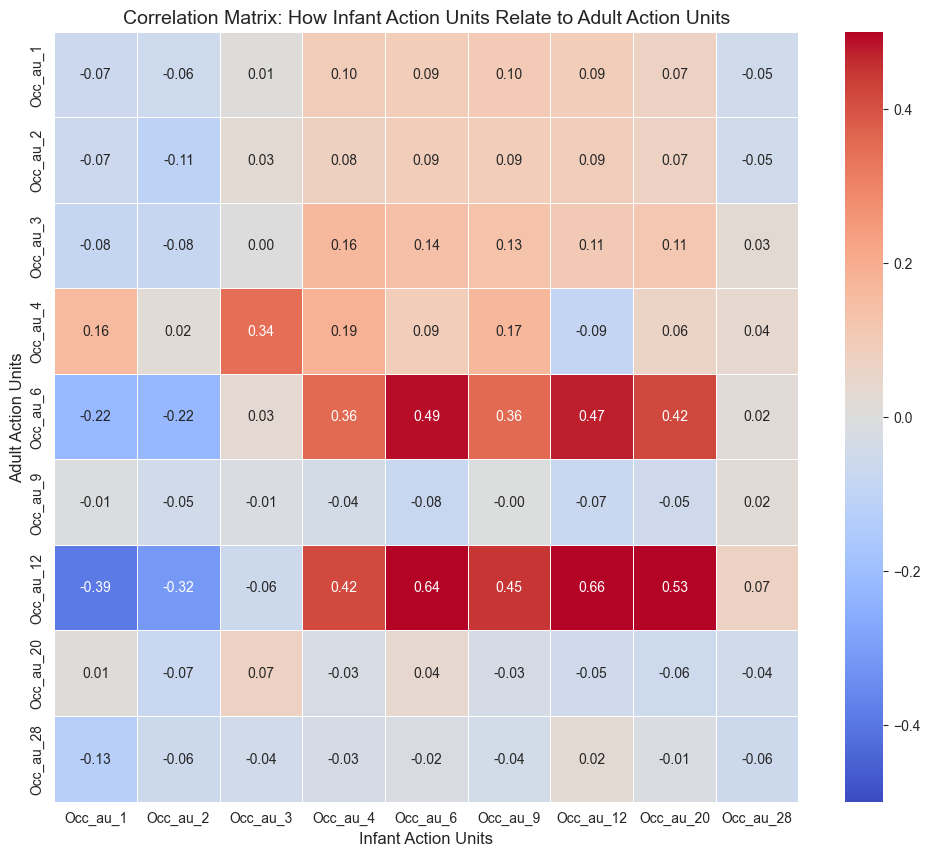

In [7]:
full_corr_matrix = pd.DataFrame(index=df_adult_processed.columns, columns=df_infant_processed.columns)

for col1 in df_adult_processed.columns:
    for col2 in df_infant_processed.columns:
        full_corr_matrix.loc[col1, col2] = df_adult_processed[col1].corr(df_infant_processed[col2])

plt.figure(figsize=(12, 10))
ax = sns.heatmap(full_corr_matrix.astype(float), annot=True, cmap='coolwarm', vmax=.5, vmin=-.5,
                 fmt='.2f', cbar=True, linewidths=0.5)
ax.set_xlabel("Infant Action Units", fontsize=12)
ax.set_ylabel("Adult Action Units", fontsize=12)
ax.set_title("Correlation Matrix: How Infant Action Units Relate to Adult Action Units", fontsize=14)
plt.show()

## Pearson and Spearman Correlation and RV Coefficient

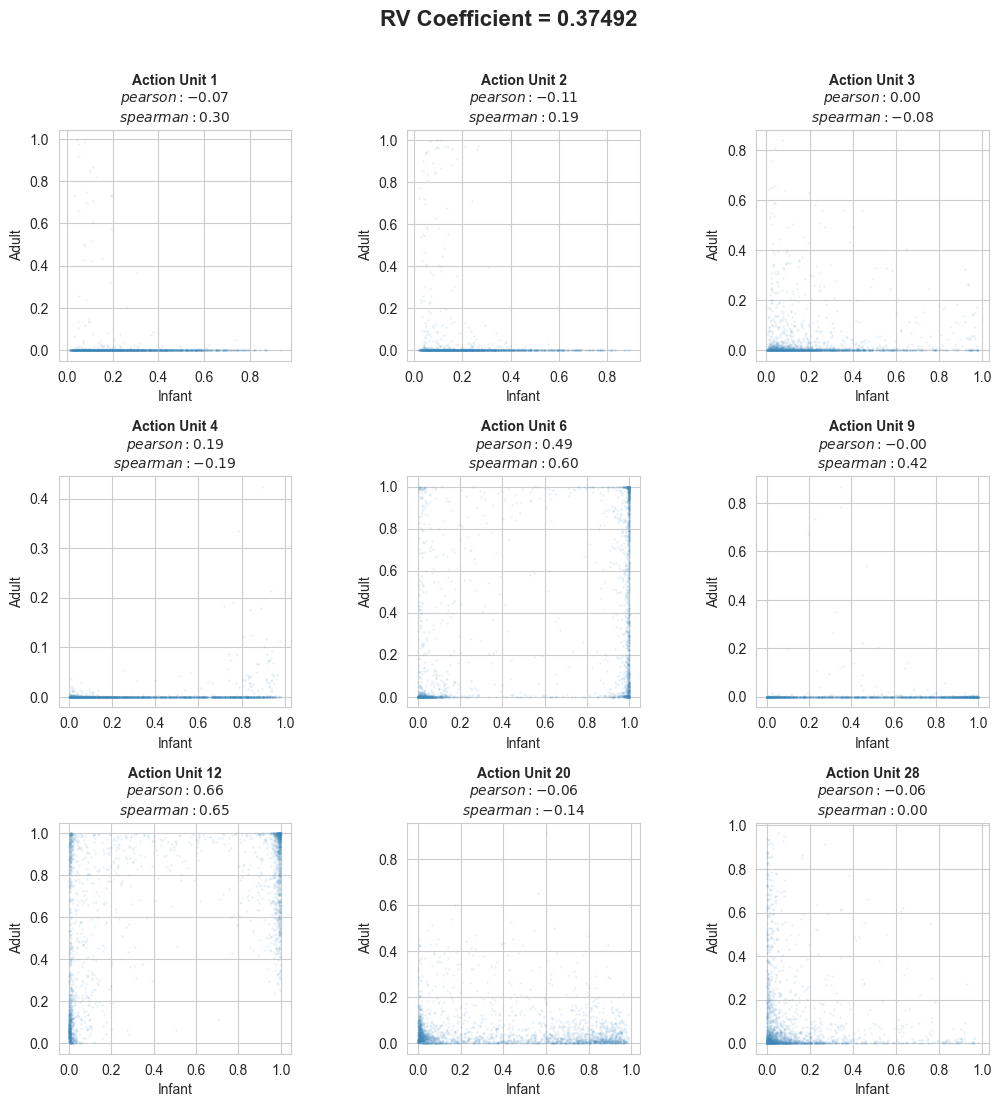

In [8]:
from scipy.stats import pearsonr, spearmanr

def cov(X, Y):
    return np.dot((X - X.mean(axis=0)).T, (Y - Y.mean(axis=0))) / X.shape[0]

def rv_coefficient(X, Y):
    X, Y = X.values, Y.values
    COVV = np.trace(np.dot(cov(X, Y), cov(Y, X)))
    VAV = np.trace(np.dot(cov(X, X), cov(X, X))) * np.trace(np.dot(cov(Y, Y), cov(Y, Y))) 
    return COVV / np.sqrt(VAV)

rv_value = rv_coefficient(df_infant_processed, df_adult_processed)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, au in enumerate(AUs):
    row, col_idx = divmod(i, 3)
    ax = axes[row, col_idx]

    p_r, p_p = pearsonr(df_infant_processed[au], df_adult_processed[au])
    s_r, s_p = spearmanr(df_infant_processed[au], df_adult_processed[au])
    
    sns.set_context("paper")
    sns.set_style("whitegrid")
    sns.scatterplot(
        x=df_infant_processed[au], 
        y=df_adult_processed[au], 
        ax=ax, 
        alpha=0.1,
        s=3,
    )

    ax.set_xlabel(f"Infant", fontsize=10)
    ax.set_ylabel(f"Adult", fontsize=10)
    ax.set_title(f"Action Unit {au[7:]}\n$pearson: {p_r:.2f}$\n$spearman: {s_r:.2f}$", 
                 fontsize=10, fontweight="bold")

fig.suptitle(f"RV Coefficient = {rv_value:.5f}", fontsize=16, fontweight="bold")

plt.show()

## Canonical Correlation Analysis

In [9]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=9)
X_c, Y_c = cca.fit_transform(df_infant_processed, df_adult_processed)

# Compute the canonical correlations for each pair of canonical variates
canonical_correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(X_c.shape[1])]

print("Canonical Correlations:")
for idx, corr in enumerate(canonical_correlations, 1):
    print(f"Component {idx}: {corr:.3f}")

Canonical Correlations:
Component 1: 0.729
Component 2: 0.504
Component 3: 0.273
Component 4: 0.178
Component 5: 0.131
Component 6: 0.124
Component 7: 0.086
Component 8: 0.068
Component 9: 0.009


## Partial least squares regression

In [10]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=9)
X_pls, Y_pls = pls.fit_transform(df_infant_processed, df_adult_processed)

# Compute the correlation between each pair of PLS components
pls_correlations = [np.corrcoef(X_pls[:, i], Y_pls[:, i])[0, 1] for i in range(X_pls.shape[1])]

print("Partial Least Squares Component Correlations:")
for idx, corr in enumerate(pls_correlations, 1):
    print(f"Component {idx}: {corr:.3f}")

Partial Least Squares Component Correlations:
Component 1: 0.049
Component 2: 0.091
Component 3: 0.029
Component 4: 0.015
Component 5: 0.051
Component 6: 0.098
Component 7: 0.057
Component 8: 0.014
Component 9: 0.028


## AUs values' histogram

In [11]:
def plot_au_histograms(df, type_str='adult'):
    # Melt DataFrame to long test_format
    df_melted = df.melt(var_name="AU", value_name="Value")
    
    # Format AU labels to be more readable
    df_melted["AU"] = df_melted["AU"].str.replace("Occ_au_", "AU ", regex=False)
    
    # Create FacetGrid
    g = sns.FacetGrid(df_melted, col="AU", col_wrap=3, height=3, sharex=True, sharey=True)
    g.map(sns.histplot, "Value", bins=20, binrange=(0, 1))
    
    # Improve y-axis labels
    for ax in g.axes.flat:
        ax.set_xticks([i / 10 for i in range(11)])  # Tick marks at 0.0, 0.1, ..., 1.0
        ax.set_xticklabels([f"{i / 10:.1f}" for i in range(11)], fontsize=8)
        ax.set_yscale("log")
        ax.set_ylabel("Count (log scale)", fontsize=9)
        ax.set_xlim([0, 1])
    
    # Adjust layout and title
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f"{type_str} AU count, fontsize=14")
    
    plt.show()

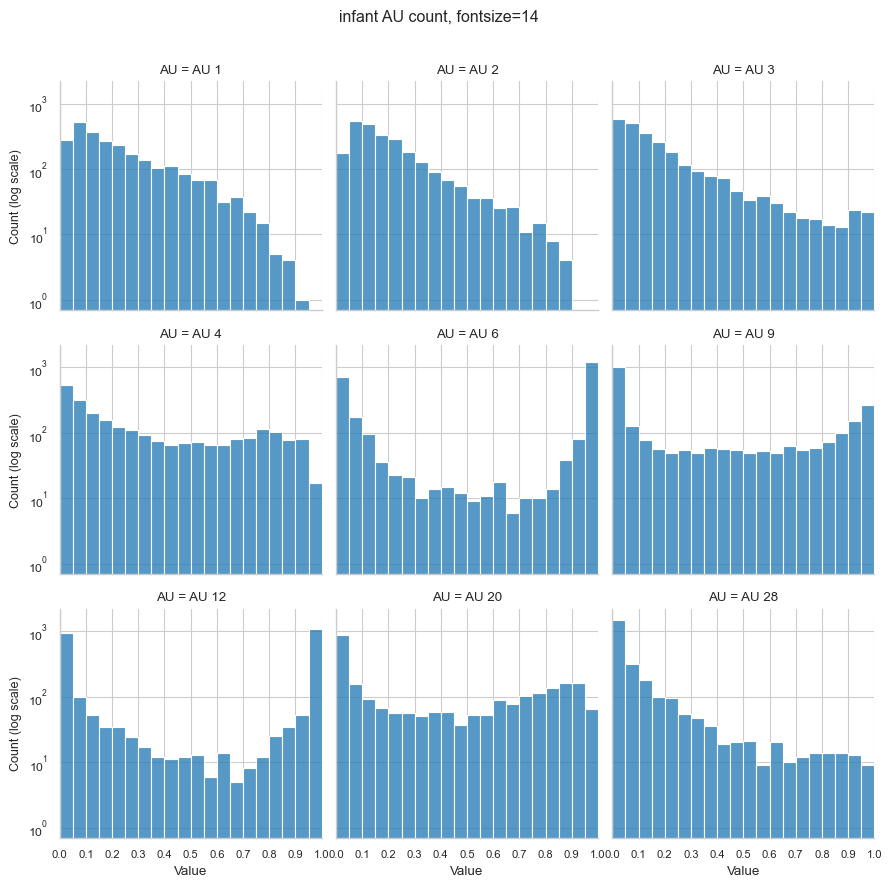

In [12]:
plot_au_histograms(df_infant_processed, type_str='infant')

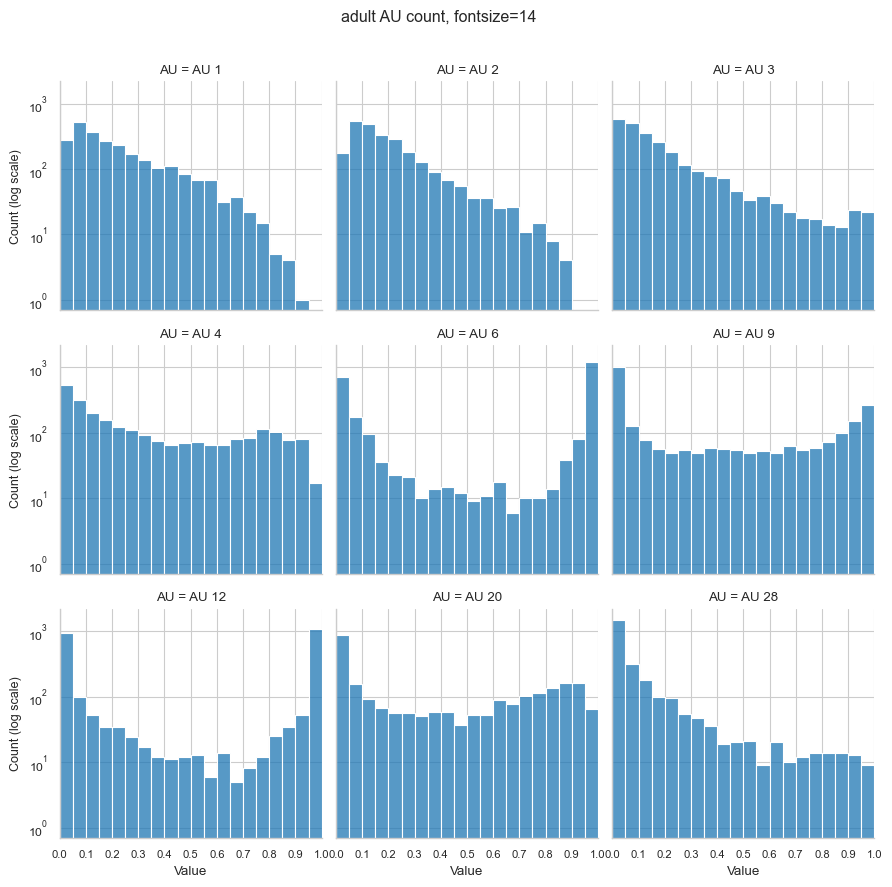

In [13]:
plot_au_histograms(df_infant_processed, type_str='adult')

# Valid segments

In [14]:
def get_valid_segments_for_both(df_infant, df_adult, min_length=150):
    valid_infant = (df_infant.iloc[:, 1:] != -1).all(axis=1)
    valid_adult = (df_adult.iloc[:, 1:] != -1).all(axis=1)
    valid_both = valid_infant & valid_adult
    
    segments_infant = []
    segments_adult = []
    current_indices = []
    
    for idx, valid in valid_both.items():
        if valid:
            current_indices.append(idx)
        else:
            if len(current_indices) >= min_length:
                segments_infant.append(df_infant.loc[current_indices])
                segments_adult.append(df_adult.loc[current_indices])
            current_indices = []

    if len(current_indices) >= min_length:
        segments_infant.append(df_infant.loc[current_indices])
        segments_adult.append(df_adult.loc[current_indices])
        
    return segments_infant, segments_adult

segments_infant, segments_adult = get_valid_segments_for_both(df_infant_full_processed, df_adult_full_processed, 
                                                              min_length=201)
print(f"The number of segemtns: {len(segments_infant)}, {len(segments_infant)}")

The number of segemtns: 4, 4


# Continuous wavelet transform

In [15]:
import pywt

def select_indices_to_filtering(data, column_name):
    coeff_approx, coeff_detail = pywt.dwt(
        data[column_name],
        'db5',
        mode='smooth'
    )

    noise_estimation = np.mean(np.power(coeff_detail, 2))
    n_samples = data[column_name].shape[0]

    threshold = np.sqrt(noise_estimation * np.log(n_samples))

    indicated_indices = 2 * np.ravel(np.argwhere(np.abs(coeff_detail) > threshold))
    return coeff_detail, indicated_indices

# Example
coeff_detail, anomaly_indices = select_indices_to_filtering(segments_infant[0], 'Occ_au_1')
len(segments_infant[0]), len(coeff_detail), anomaly_indices

(1695,
 852,
 array([   2,  226,  250,  264,  266,  290,  406,  460,  472,  506,  574,
        1186, 1274, 1278, 1310, 1314, 1340, 1666, 1676], dtype=int64))

# Lag Correlation

Average Perason lag correlation across all segments

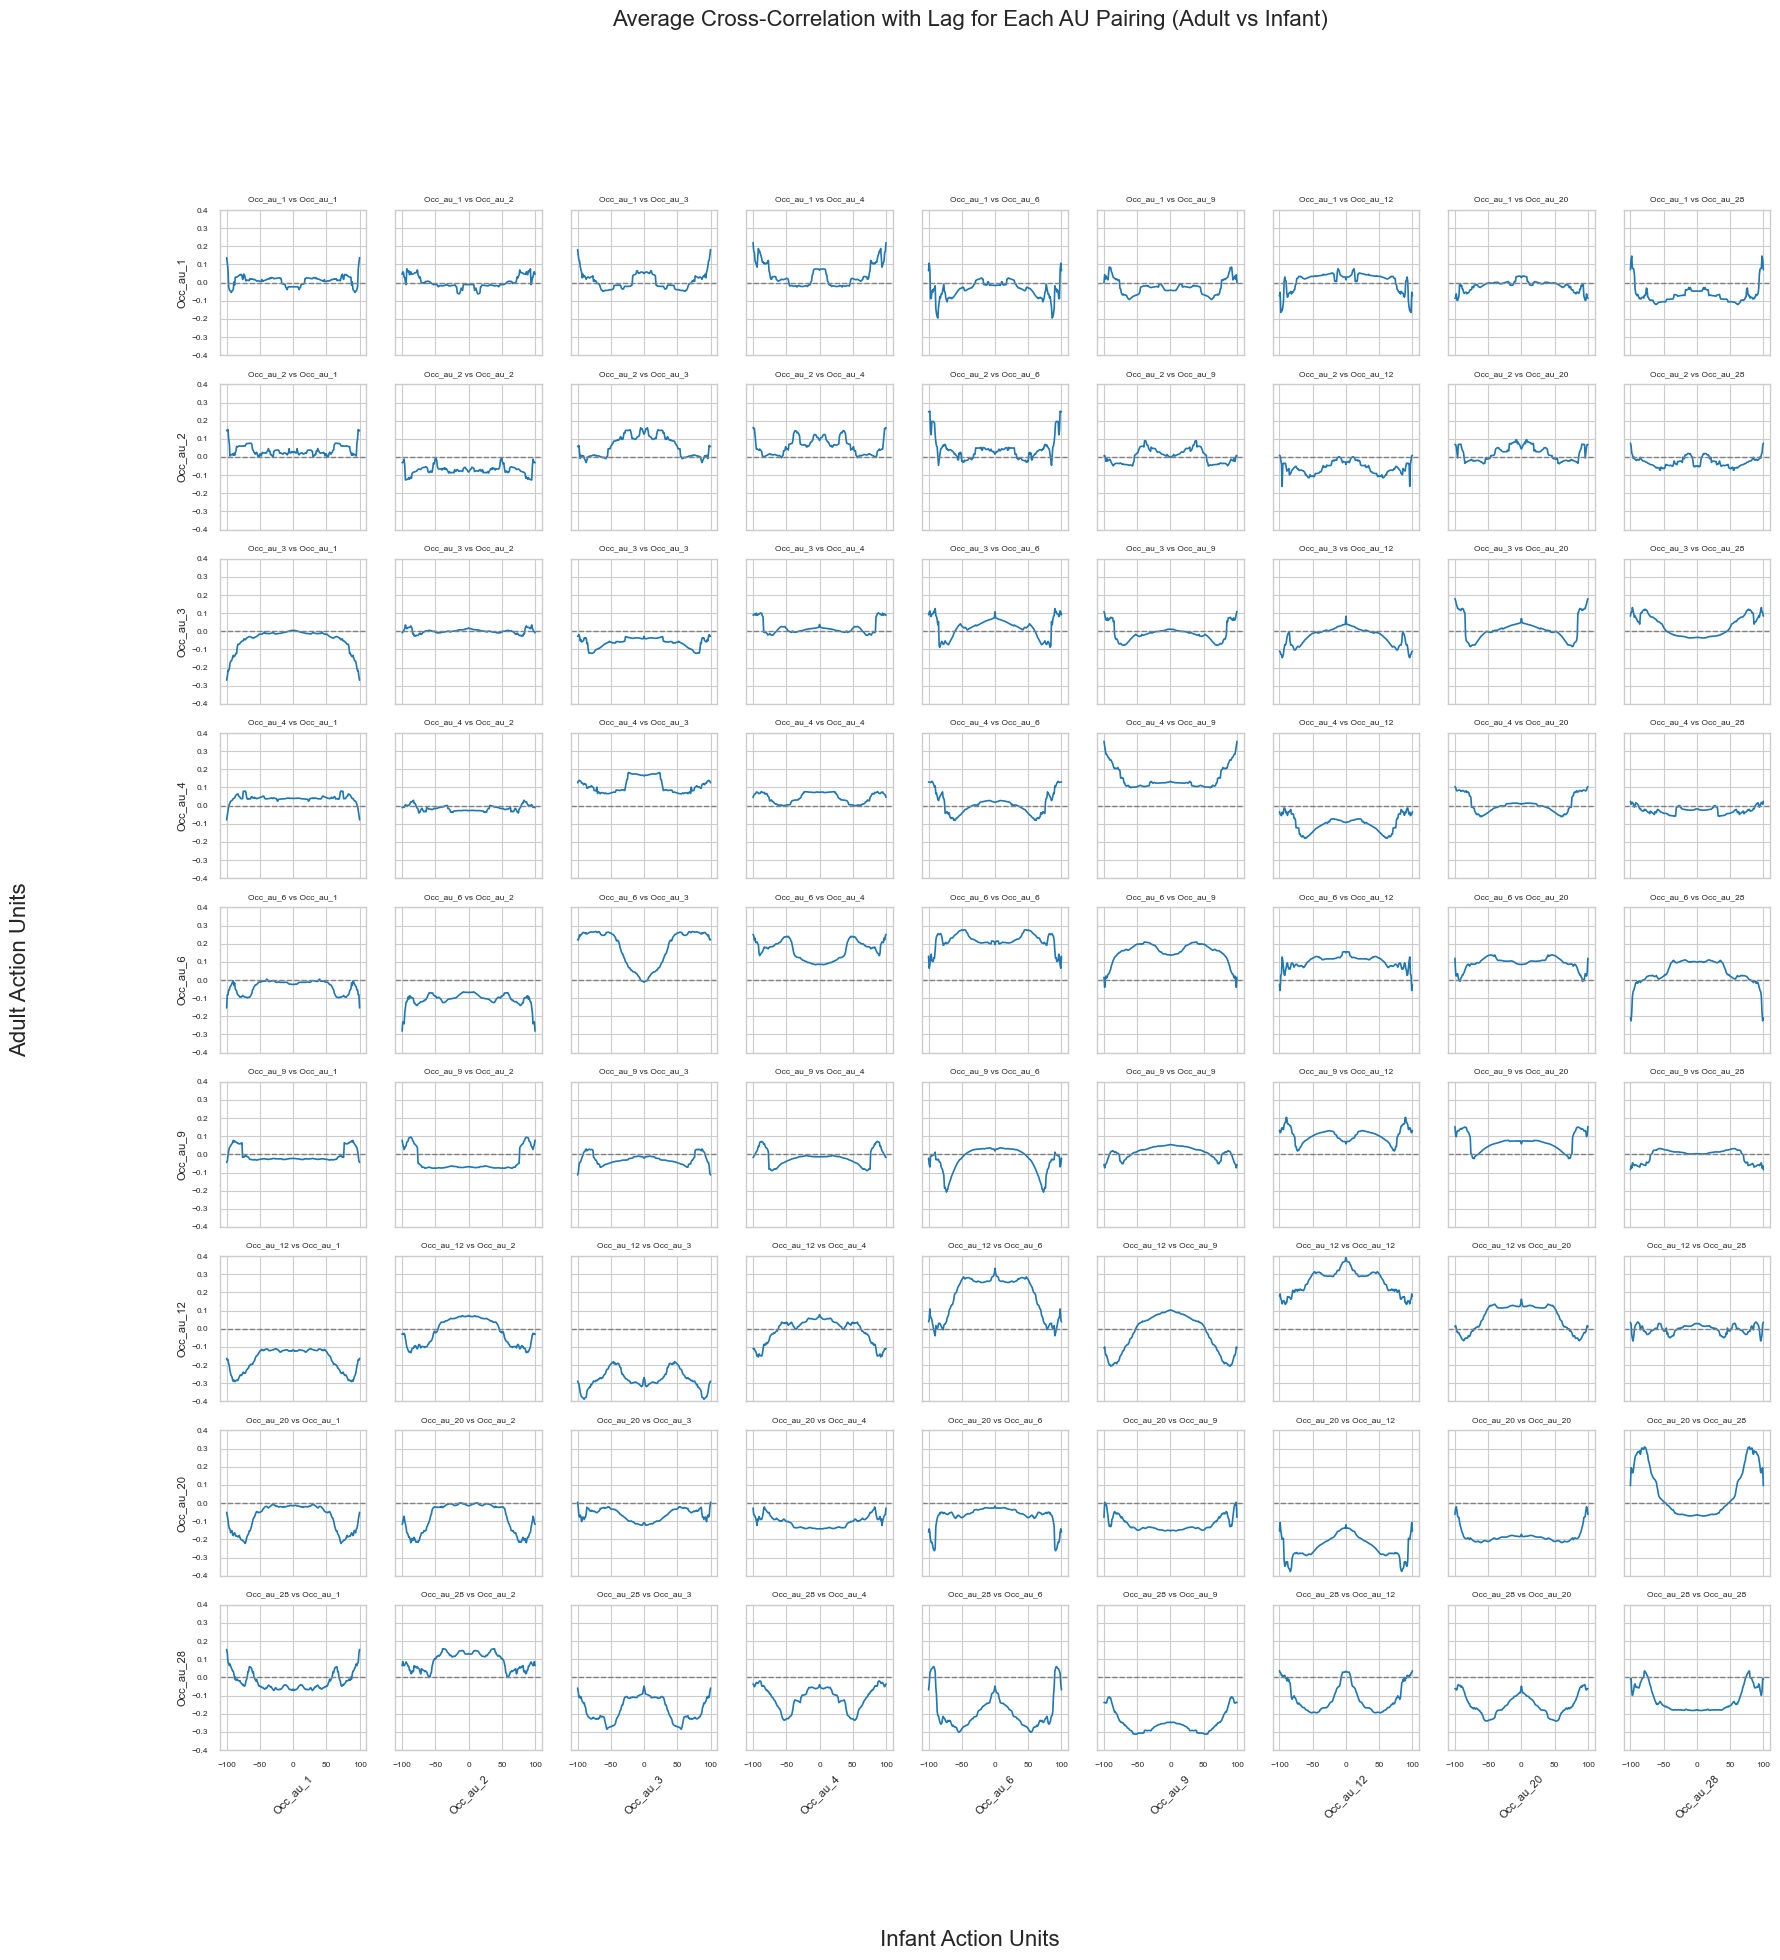

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_segment_cross_corr(series1, series2, lag_range):
    """
    Computes the Pearson correlation between two time series for different lags.
    
    Parameters:
      series1: First time series (e.g., from adult data).
      series2: Second time series (e.g., from infant data).
      lag_range: The maximum absolute lag to consider. 
                 The function computes correlations for lags from -lag_range to +lag_range.
                 
    Returns:
      A pandas Series with lags as the index and the corresponding correlation values.
    """
    # Create an array of lag values from -lag_range to +lag_range
    lags = np.arange(-lag_range, lag_range + 1)
    correlations = []
    
    # Loop through each lag and compute the correlation
    for lag in lags:
        if lag < 0:
            # For negative lag: truncate the end of series1 and the beginning of series2
            corr = series1[:lag].corr(series2[-lag:], method='pearson')
        elif lag > 0:
            # For positive lag: truncate the beginning of series1 and the end of series2
            corr = series1[lag:].corr(series2[:-lag], method='pearson')
        else:
            # Lag 0: compute the correlation on the full series
            corr = series1.corr(series2, method='pearson')
        correlations.append(corr)
    
    return pd.Series(correlations, index=lags)

# List of Action Units (AU) for both adult and infant
au_columns = ['Occ_au_1', 'Occ_au_2', 'Occ_au_3', 'Occ_au_4', 
              'Occ_au_6', 'Occ_au_9', 'Occ_au_12', 'Occ_au_20', 'Occ_au_28']

# Hyperparameter: maximum lag (absolute value) to consider.
# This means correlations will be computed for lags from -lag_range to +lag_range.
lag_range = 100

# Create a dictionary to store the averaged cross-correlation for each AU pairing.
# The keys are tuples in the form (adult_AU, infant_AU)
avg_corr_dict = {}
for adult_au in au_columns:
    for infant_au in au_columns:
        segment_correlations = []
        # Loop over the corresponding valid segments for infant and adult data
        for seg_inf, seg_ad in zip(segments_infant, segments_adult):
            # Ensure the segment is long enough to compute the correlations for the given lag_range
            if len(seg_inf) > lag_range and len(seg_ad) > lag_range:
                # Extract the time series for the specific action unit from infant and adult segments
                series_inf = seg_inf[infant_au]
                series_ad = seg_ad[adult_au]
                # Compute the cross-correlation for this segment
                corr_series = compute_segment_cross_corr(series_ad, series_inf, lag_range)
                segment_correlations.append(corr_series)
        # Average the correlation series across segments, if any exist for this pairing
        if segment_correlations:
            df_corrs = pd.DataFrame(segment_correlations)
            avg_corr = df_corrs.mean()
        else:
            # If no segments are available, fill with NaN values
            avg_corr = pd.Series([np.nan] * (2 * lag_range + 1), index=np.arange(-lag_range, lag_range + 1))
        avg_corr_dict[(adult_au, infant_au)] = avg_corr

# Create a 9x9 grid of plots (rows: adult AUs, columns: infant AUs)
fig, axs = plt.subplots(nrows=len(au_columns), ncols=len(au_columns),
                        figsize=(20, 20), sharex=True, sharey=True)

# Loop through each subplot and plot the averaged correlation vs. lag
for i, adult_au in enumerate(au_columns):
    for j, infant_au in enumerate(au_columns):
        ax = axs[i, j]
        avg_corr = avg_corr_dict[(adult_au, infant_au)]
        ax.plot(avg_corr.index, avg_corr.values, linestyle='-')
        # Draw a horizontal line at 0 for reference
        ax.axhline(0, color='gray', linestyle='--', linewidth=1)
        # Label the x-axis only on the bottom row
        if i == len(au_columns) - 1:
            ax.set_xlabel(infant_au, fontsize=8, rotation=45)
        # Label the y-axis only on the first column
        if j == 0:
            ax.set_ylabel(adult_au, fontsize=8)
            
        ax.set_ylim(-0.4, 0.4)
        ax.set_title(f'{adult_au} vs {infant_au}', fontsize=6)
        ax.tick_params(axis='both', labelsize=6)


fig.suptitle('Average Cross-Correlation with Lag for Each AU Pairing (Adult vs Infant)', fontsize=16)
fig.supylabel('Adult Action Units', fontsize=16)
fig.supxlabel('Infant Action Units', fontsize=16)
plt.show()

## Cross Recurrence Plot

In [17]:
from pyunicorn.timeseries import CrossRecurrencePlot
import math

def plot_cross_recurrence(x, y, metric="euclidean", threshold=None, dim=None, tau=None, recurrence_rate=0.1, ax=None):
    crp = CrossRecurrencePlot(x=x, y=y, dim=dim, tau=tau, recurrence_rate=recurrence_rate, 
                              metric=metric, threshold=threshold)
    
    R_dense = crp.recurrence_matrix().astype(float)
    print(f"Recurrence matrix shape: {R_dense.shape}")
    
    if ax is not None:
        ax.imshow(R_dense, origin="lower", cmap="binary", aspect="auto")
        ax.set_xlabel("Adult Time Index")
        ax.set_ylabel("Infant Time Index")
    else:
        plt.figure(figsize=(8, 8))
        plt.imshow(R_dense, origin="lower", cmap="binary", aspect="auto")
        plt.xlabel("Adult Time Index")
        plt.ylabel("Infant Time Index")
        plt.colorbar(label="Recurrence")
        plt.title(f"Cross-Recurrence Plot")
        plt.show()

def plot_cross_recurrence_separate(x, y, metric="euclidean", threshold=None, dim=None, tau=None, recurrence_rate=0.1):
    columns, rows = 3, math.ceil(len(x.columns) / 3)
    fig, axes = plt.subplots(rows, columns, figsize=(4 * columns, 4 * rows))
    axes = axes.flatten()
    
    for i, au in enumerate(x.columns):
        x_feature = x.iloc[:, i].values.reshape(-1, 1)
        y_feature = y.iloc[:, i].values.reshape(-1, 1)

        plot_cross_recurrence(x=x_feature, y=y_feature, metric=metric, threshold=threshold, dim=dim, 
                              tau=tau, recurrence_rate=recurrence_rate,ax=axes[i])
        axes[i].set_title(au)
        
    plt.tight_layout()
    plt.show()

Calculating cross recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Recurrence matrix shape: (1695, 1695)


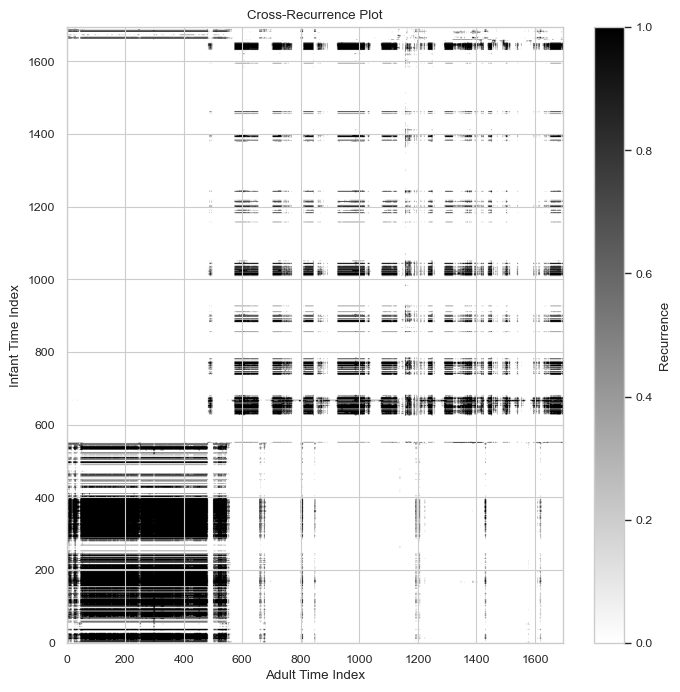

In [18]:
# Everything
plot_cross_recurrence(x=segments_infant[0].values,
                      y=segments_adult[0].values,
                      metric="euclidean", 
                      threshold=None, 
                      dim=None, 
                      tau=None,
                      recurrence_rate=0.1)

Calculating cross recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Recurrence matrix shape: (1685, 1685)
Calculating cross recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Recurrence matrix shape: (1685, 1685)
Calculating cross recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Recurrence matrix shape: (1685, 1685)


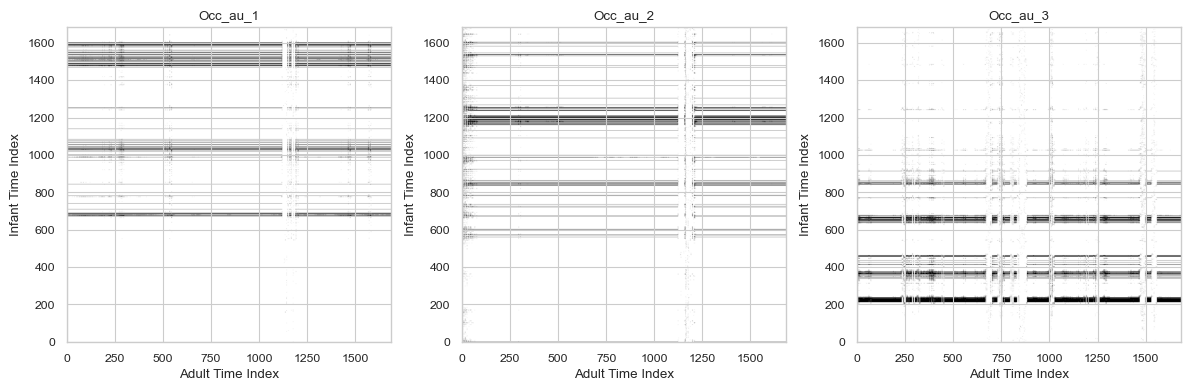

In [19]:
# Separately
plot_cross_recurrence_separate(x=segments_infant[0].iloc[:, :3],
                               y=segments_adult[0].iloc[:, :3],
                               metric="euclidean",
                               threshold=None, 
                               dim=2,
                               tau=10, 
                               recurrence_rate=0.05)